In [6]:
#mass is in units of 10e10 M_solar
#distances are in Kpc

#standard imports
import glob
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import sys

%matplotlib inline

#setting matplotlib parameters
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [7]:
#set matplotlib global font size
matplotlib.rcParams['font.size']=14

In [8]:
path = '/home/ryan/projects/Medvedev/snaps/run_20210302/'

snaps = glob.glob(path + 'snapdir_127/' + '*.hdf5')

In [9]:
with h5py.File(path+"snapdir_127/snap_127.0.hdf5", "r") as f:
    print(f['Header'].attrs['NumPart_Total'])

[2313531  114400 2190078       0    4608      13]


In [10]:
#get the total number of particles
with h5py.File(path+"snapdir_127/snap_127.0.hdf5", "r") as f:
    num_pt1 = f['Header'].attrs['NumPart_Total'][1] #total number of parttype1 (pt1) particles
    num_pt2 = f['Header'].attrs['NumPart_Total'][2] #total number of parttype2 (pt2) particles
    num_pt0 = f['Header'].attrs['NumPart_Total'][0]
    masses_pt1 = f['Header'].attrs['MassTable'][1] #mass of all parttype1 particles (in code units)

#initialize empty arrays
coords_pt2 = np.zeros((num_pt2, 3))
masses_pt2 = np.zeros(num_pt2)
coords_pt1 = np.zeros((num_pt1, 3))
coords_pt0 = np.zeros((num_pt0, 3))

#fill arrays 
pt0_so_far = 0
pt1_so_far = 0
pt2_so_far = 0
for i in range(len(snaps)): #loop over all snapshot chunks
    with h5py.File(path+f"snapdir_127/snap_127.{i}.hdf5", "r") as f: #open the file 
        pt0_this_file = f["Header"].attrs['NumPart_ThisFile'][0]
        pt1_this_file = f["Header"].attrs['NumPart_ThisFile'][1] #number of pt1 in this chunk
        pt2_this_file = f["Header"].attrs['NumPart_ThisFile'][2]
        coords_pt2[pt2_so_far:pt2_so_far+pt2_this_file] = f["PartType2/Coordinates"] #get the data
        coords_pt1[pt1_so_far:pt1_so_far+pt1_this_file] = f["PartType1/Coordinates"]
        coords_pt0[pt0_so_far:pt0_so_far+pt0_this_file] = f["PartType0/Coordinates"]
        masses_pt2[pt2_so_far:pt2_so_far+pt2_this_file] = f["PartType2/Masses"] 
        pt1_so_far += pt1_this_file #increase index counter
        pt2_so_far += pt2_this_file
        pt0_so_far += pt0_this_file

#convert from code units to solar masses
masses_pt1 *= 1e10/0.7
masses_pt2 *= 1e10/0.7

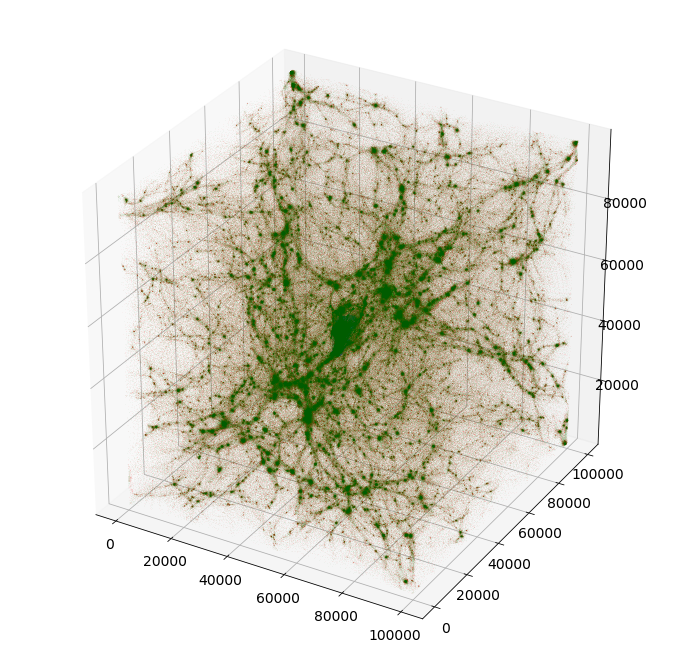

In [11]:
fig = plt.figure(figsize=[12,12])

ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot3D(coords_pt2[:,0], coords_pt2[:,1], coords_pt2[:,2],'o', color='r',markersize=0.1, alpha=0.1, label='Low Resolution DM')
ax.plot3D(coords_pt1[:,0], coords_pt1[:,1], coords_pt1[:,2],'o', color='b',markersize=0.1, alpha=0.1, label='High Resolution DM')
ax.plot3D(coords_pt0[:,0], coords_pt0[:,1], coords_pt0[:,2],'o', color='g',markersize=0.1, alpha=0.1, label='Gas')
#ax.set_title('Looking at IC')
plt.show()

In [12]:
with h5py.File(path+"groups_127/fof_subhalo_tab_127.0.hdf5", "r") as f:
    num_part_type = np.array(f["Subhalo/SubhaloLenType"])[0]
shalo0_pt1_coords = coords_pt1[:num_part_type[1]]
shalo0_pt2_coords = coords_pt2[:num_part_type[2]]
shalo0_pt2_masses = masses_pt2[:num_part_type[2]]
shalo0_pt0_coords = coords_pt0[:num_part_type[0]]

shalo0_coords = np.concatenate((shalo0_pt2_coords, shalo0_pt1_coords))
shalo0_masses = np.concatenate((shalo0_pt2_masses, [masses_pt1]*shalo0_pt1_coords.shape[0]))

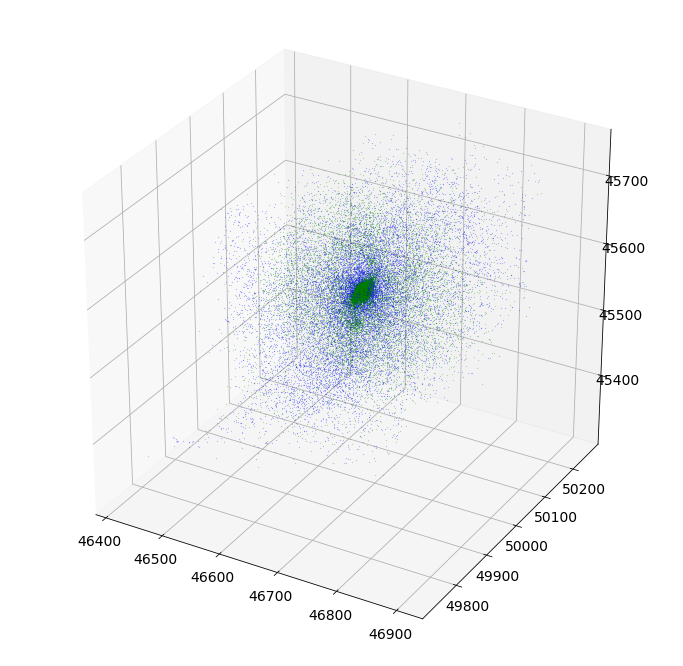

In [13]:
fig = plt.figure(figsize=[12,12])

ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot3D(shalo0_pt2_coords[:,0], shalo0_pt2_coords[:,1], shalo0_pt2_coords[:,2],'o', color='r',markersize=0.1, alpha=1, label='Low Resolution DM')
ax.plot3D(shalo0_pt1_coords[:,0], shalo0_pt1_coords[:,1], shalo0_pt1_coords[:,2],'o', color='b',markersize=0.1, alpha=1, label='High Resolution DM')
ax.plot3D(shalo0_pt0_coords[:,0], shalo0_pt0_coords[:,1], shalo0_pt0_coords[:,2],'o', color='g',markersize=0.1, alpha=1, label='High Resolution DM')

offset=0

ax.set_xlim(np.amin(shalo0_coords[:,0])+offset, np.amax(shalo0_coords[:,0])-offset)
ax.set_ylim(np.amin(shalo0_coords[:,1])+offset, np.amax(shalo0_coords[:,1])-offset)
ax.set_zlim(np.amin(shalo0_coords[:,2])+offset, np.amax(shalo0_coords[:,2])-offset)

#ax.set_title('Looking at IC')
plt.show()

Text(0.5, 1.0, 'Subhalo0 - PartType2')

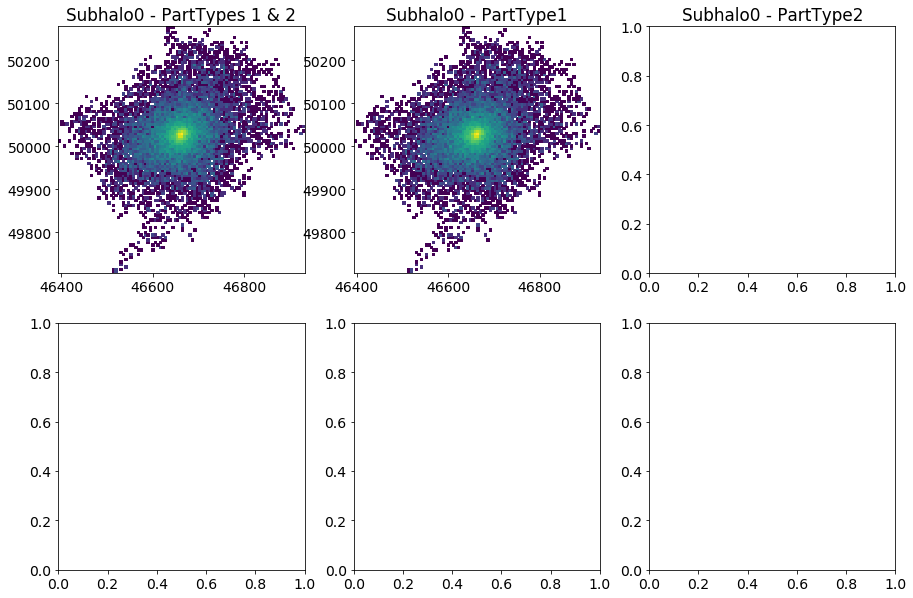

In [23]:
from matplotlib.colors import LogNorm
#plot the data 
fig, ax = plt.subplots(2,3, figsize=(15,10))
bins = 100
#plot the subhalo data
ax[0,0].hist2d(shalo0_coords[:,0], shalo0_coords[:, 1], weights=shalo0_masses, bins=bins, norm=LogNorm())
ax[0,1].hist2d(shalo0_pt1_coords[:,0], shalo0_pt1_coords[:,1], bins=bins, norm=LogNorm())
ax[0,2].hist2d(shalo0_pt2_coords[:,0], shalo0_pt2_coords[:,1], weights=shalo0_pt2_masses, bins=bins, norm=LogNorm())

ax[0,0].set_title("Subhalo0 - PartTypes 1 & 2")
ax[0,1].set_title("Subhalo0 - PartType1")
ax[0,2].set_title("Subhalo0 - PartType2")

In [9]:
with h5py.File('/home/ryan/Downloads/snap_022121_2CDM_005(4).hdf5', 'r') as f:
    print(f['Header'].attrs['NumPart_Total'])

[253867 262144      0      0      0      0]


In [7]:
with h5py.File('/home/ryan/Downloads/snap_022121_2CDM_005(4).hdf5', 'r') as f:
    num_pt1 = f['Header'].attrs['NumPart_Total'][1] #total number of parttype1 (pt1) particles
    num_pt0 = f['Header'].attrs['NumPart_Total'][0]
    #coords_pt2 = f["PartType2/Coordinates"] #get the data
    coords_pt1 = np.zeros((num_pt1, 3))
    coords_pt0 = np.zeros((num_pt0, 3))
    coords_pt1[0:num_pt1] = f["PartType1/Coordinates"]
    coords_pt0[0:num_pt1] = f["PartType0/Coordinates"]

        

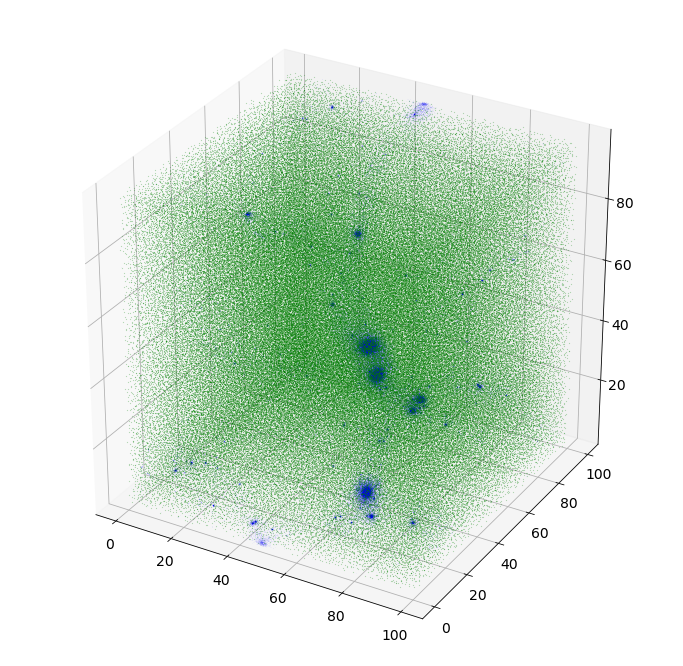

In [11]:
fig = plt.figure(figsize=[12,12])

ax = fig.add_subplot(1,1,1, projection='3d')

#ax.plot3D(coords_pt2[:,0], coords_pt2[:,1], coords_pt2[:,2],'o', color='r',markersize=0.1, alpha=0.1, label='Low Resolution DM')
ax.plot3D(coords_pt1[:,0], coords_pt1[:,1], coords_pt1[:,2],'o', color='b',markersize=0.1, alpha=0.1, label='High Resolution DM')
ax.plot3D(coords_pt0[:,0], coords_pt0[:,1], coords_pt0[:,2],'o', color='g',markersize=0.1, alpha=1, label='Gas')
#ax.set_title('Looking at IC')
plt.show()